# ***Why you should use a framework***

This notebook has been prepared by me and is based on the fast.ai's Notebook, which can be found at the following link: https://www.kaggle.com/code/jhoward/why-you-should-use-a-framework.

Review it for a comprehensive explanation.

## ***Introduction***

In [1]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [2]:
creds = '{"username":"","key":""}'

In [3]:
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [4]:
path = Path('titanic')

In [5]:
if not iskaggle and not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 34.1k/34.1k [00:00<00:00, 17.9MB/s]

In [6]:
if iskaggle:
    path = Path('../input/titanic')

In [7]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.9 MB/s eta 0:00:00


In [8]:
!ls {path}

gender_submission.csv  test.csv  train.csv


In [9]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

## ***Prep the data***

In [10]:
df = pd.read_csv(path/'train.csv')

In [11]:
def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==0
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master"))

add_features(df)

In [12]:
splits = RandomSplitter(seed=42)(df)

In [ ]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["Sex","Pclass","Embarked","Deck", "Title"],
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    y_names="Survived", y_block = CategoryBlock(),
).dataloaders(path=".")

## ***Train the model***

In [14]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_co

SuggestedLRs(slide=0.05754399299621582, valley=0.013182567432522774)

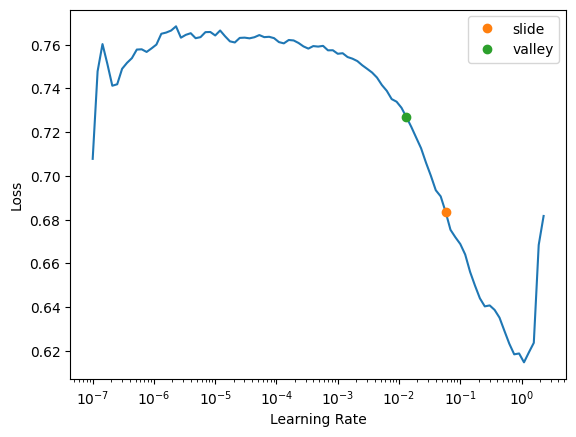

In [15]:
learn.lr_find(suggest_funcs=(slide, valley))

In [16]:
learn.fit(16, lr=0.03)

epoch,train_loss,valid_loss,accuracy,time
0,0.577146,0.582949,0.606742,00:00
1,0.510818,0.498523,0.786517,00:00
2,0.467023,0.459841,0.797753,00:00
3,0.439957,0.468547,0.797753,00:00
4,0.427232,0.415261,0.825843,00:00
5,0.416340,0.437362,0.820225,00:00
6,0.408347,0.413253,0.848315,00:00
7,0.400442,0.406075,0.803371,00:00
8,0.397265,0.443730,0.820225,00:00
9,0.392389,0.432267,0.831461,00:00


/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_co

## ***Submit to Kaggle***

In [17]:
tst_df = pd.read_csv(path/'test.csv')
tst_df['Fare'] = tst_df.Fare.fillna(0)
add_features(tst_df)

In [18]:
tst_dl = learn.dls.test_dl(tst_df)

In [ ]:
preds,_ = learn.get_preds(dl=tst_dl)

In [20]:
tst_df['Survived'] = (preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)

In [21]:
!head sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,1
899,0
900,1


## ***Ensembling***

In [22]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])
    with learn.no_bar(),learn.no_logging(): learn.fit(16, lr=0.03)
    return learn.get_preds(dl=tst_dl)[0]

In [ ]:
learns = [ensemble() for _ in range(5)]

In [24]:
ens_preds = torch.stack(learns).mean(0)

In [25]:
tst_df['Survived'] = (ens_preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('ens_sub.csv', index=False)